# 导入包

In [1]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle
import function

## 函数定义

In [2]:
def bins_divide(data, relative_data, bins_num):
    bins_interval = np.linspace(np.min(data) * 0.99, max(data) * 1.01, bins_num + 1)
    bins_center_interval = (bins_interval[:-1] + bins_interval[1:]) / 2

    bins_dis = []
    bins_mean = []
    bins_id_data = np.digitize(data, bins_interval) - 1

    for i in range(0, bins_num):
        index_divide = bins_id_data == i
        bins_dis.append(np.std(relative_data[index_divide]))
        bins_mean.append(np.mean(relative_data[index_divide]))

    return bins_center_interval, bins_mean, bins_dis

# Source-Extractor处理和结果

## 文件路径和信息

In [8]:
CONFIG_PATH_1 = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/"
CONFIG_PATH_2 = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data_validate/"

band = "C1"
band_short = "g"
band_short_capital = "G"
band_index = 2
day = "240119"
obs_index = "07"
unkonw_index = "01"
exp_time = 300

obs_info = {"01": "20240119020742_20240119021242", "02" :"20240119021141_20240119021641", "03": "20240119021742_20240119022242", "04": "20240119022342_20240119022842", "05": "20240119022941_20240119023441"}

img_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_img.fits'
flg_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_flg.fits'
wht_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_wht.fits'

sext_config_path: str = CONFIG_PATH_1 + "astrom.sex"
sext_para_path: str = CONFIG_PATH_1 + "astrom.param"
sext_filter_path: str = CONFIG_PATH_1 + "gauss_4.0_7x7.conv"
# sext_config_path: str = CONFIG_PATH_2 + "default.sex"
# sext_para_path: str = CONFIG_PATH_1 + "default.param"
# sext_filter_path: str = CONFIG_PATH_2 + "default.conv"
sext_out_path: str = os.path.basename(img_path).replace(".fits", ".acat")
# sext_out_path: str = f"{band}_{exp_time}_out.fits"

In [13]:
hdul = fits.open(sext_out_path)
hdul

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff97c71ae10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff97c6f5850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff97c73a2d0>]

In [10]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

print(f"reference point pixel, {x_ref}, {y_ref}")
print(f"reference point celestical, {pointing_ra}, {pointing_dec}")

reference point pixel, 4607.5, 4615.5
reference point celestical, 265.1745710308334, -54.09801556935517


## Source-Extractor结果

### 读取已有或直接处理fits图像

In [11]:
fp_img = img_path
fp_flg = flg_path
fp_wht = wht_path
fp_config_sext = sext_config_path
fp_out_sext = sext_out_path
fp_para_sext = sext_para_path
fp_filter_sext = sext_filter_path

function.work_sext(fp_img,fp_config_sext,fp_out_sext, fp_flg, fp_wht, fp_para_sext,fp_filter_sext)
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out = Table(hdu_list[2].data)

> 
----- SExtractor 2.25.0 started on 2024-05-30 at 17:02:00 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.fits
----- Measuring from: CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.fits [1/1]
      "Unnamed" / no ext. header / 9216x9232 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up backgrou

Filename: CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.acat
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [13440A]   
  2  LDAC_OBJECTS    1 BinTableHDU    163   6925R x 39C   [1E, 1E, 1E, 1E, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1J, 1J, 1J, 1J, 1E, 1D, 1D, 1E, 1D, 1D, 1E, 1E, 1E, 1D, 1D, 1E, 1I]   


> Line: 9232  Objects:     6948 detected /     6800 sextracted
      Objects: detected 6948     / sextracted 6925            

> Closing files
> 
> All done (in 25.4 s: 363.9 lines/s , 273.0 detections/s)


In [23]:
cmd_sex = (
    "sex -c "
    + '/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/astrom.sex'
    + " "
    + '/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.fits'
    + " -CATALOG_NAME "
    + 'CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.acat'
    + " -FLAG_IMAGE "
    # + fp_flg
    + " -WEIGHT_IMAGE "
    # + fp_wht
    + " -PARAMETERS_NAME "
    + "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/astrom.param"
    + " -FILTER_NAME "
    + '/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/gauss_4.0_7x7.conv'
)
os.system(cmd_sex)

> 
----- SExtractor 2.25.0 started on 2024-05-30 at 17:34:59 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.fits
----- Measuring from: CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.fits [1/1]
      "Unnamed" / no ext. header / 9216x9232 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up backgrou

0

In [33]:
hdul = fits.open('CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.acat')
data = Table(hdul[2].data)
data
def write_reg(
    data,
    fp_reg: str,
    X_term: str,
    Y_term: str,
):
    """
    Write data to file, *.reg.

    Write positions of filtered data to file, *.reg.

    Parameters
    ----------
    data : fits.fitsrec.FITS_rec
        The filtered data of the Source-Extractor output.
    fp_reg : str
        The reg fits.
    X_term : str
        The X-axis name.
    Y_term : str
        The Y-axis name.

    Returns
    -------
    None

    Examples
    -------
    >>> write_reg(tdata, filesatreg, "X_IMAGE", "Y_IMAGE")
    """
    with open(fp_reg, "a") as f:
        f.write(
            'global color=red dashlist=8 3 width=1 font="helvetica 10 normal roman" '
            "select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1"
            + "\n"
        )
        f.write("physical" + "\n")
        for i in range(len(data)):
            f.write(
                "circle("
                + str("%12.6f" % data[X_term][i])
                + ",  "
                + str("%12.6f" % data[Y_term][i])
                + ","
                + str(8)
                + ")"
                + "\n"
            )
write_reg(data, "CSST_MCI_C1_STAR_20240119020742_20240119021242_20200000001_07_L1_V01_img.acat.reg", "X_IMAGE", "Y_IMAGE")

In [21]:
cmd_sex = (
    "sex -c "
    + '/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/astrom.sex'
    + " "
    + '/nfsdata/share/pipeline-unittest/csst_mci/data/dfs_dummy/L1/sim_ver20230725/20100000001/ins_output/CSST_MCI_C1_EXDF_20230918003941_20230918004441_20100000001_07_L1_V01_img.fits'
    + " -CATALOG_NAME "
    + '/nfsdata/share/pipeline-unittest/csst_mci/data/dfs_dummy/L1/sim_ver20230725/20100000001/ins_output/CSST_MCI_C1_EXDF_20230918003941_20230918004441_20100000001_07_L1_V01_img.acat'
    + " -FLAG_IMAGE "
    # + fp_flg
    + " -WEIGHT_IMAGE "
    # + fp_wht
    + " -PARAMETERS_NAME "
    + "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/astrom.param"
    + " -FILTER_NAME "
    + '/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/gauss_4.0_7x7.conv'
)
os.system(cmd_sex)

> 
----- SExtractor 2.25.0 started on 2024-05-30 at 17:26:21 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for CSST_MCI_C1_EXDF_20230918003941_20230918004441_20100000001_07_L1_V01_img.fits
----- Measuring from: CSST_MCI_C1_EXDF_20230918003941_20230918004441_20100000001_07_L1_V01_img.fits [1/1]
      "Unnamed" / no ext. header / 9216x9232 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up backgrou

0

In [43]:
log_path = "/home/fangwf/MCI_SimData/240119/L0/log_Data"
filename = "star_info_SN_1.fits"

hdu_info = fits.open(os.path.join(log_path, filename))
l0_info = Table(hdu_info[1].data)
filter_x = l0_info[f"posX_{band}"]
filter_y = 9232 - l0_info[f"posY_{band}"]
filter_mag = l0_info["st_magbp"]

sext_out["filter"] = 0
sext_out[f"mag_{band}"] = np.zeros_like(sext_out["filter"], dtype=float)

for l0_x, l0_y, l0_mag in zip(filter_x, filter_y, filter_mag):
    index = (sext_out["XWIN_IMAGE"] - l0_x) ** 2 + (sext_out["YWIN_IMAGE"] - l0_y) ** 2 < 4
    if np.sum(index) == 1:
        sext_out["filter"][index] = 1
        sext_out[f"mag_{band}"][index] = l0_mag

sext_out_filter = sext_out[sext_out["filter"] == 1]

In [44]:
sext_out_filter

X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,XMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,YMIN_IMAGE,ALPHA_J2000,DELTA_J2000,ALPHAWIN_J2000,DELTAWIN_J2000,X_WORLD,Y_WORLD,X2WIN_IMAGE,Y2WIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,THETAWIN_IMAGE,ERRTHETAWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,ELLIPTICITY,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,FLUX_AUTO,FLUXERR_AUTO,BACKGROUND,MAG_AUTO,MAGERR_AUTO,ISOAREAF_IMAGE,FWHM_IMAGE,FLAGS,filter,mag_C1
float32,float32,float64,float64,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,int64,float64
8026.265,152.37714,8026.010750127309,152.54623156179645,7992,8061,186,116,265.09347647040494,-54.15997612236688,265.09348250675606,-54.15997377794243,265.09347647040494,-54.15997612236688,1.7172780121770967,1.068824795360749,0.0009715177742802655,0.0006138814928419776,1.3190415,1.0228549,0.031276267,0.024641313,10.397397,7.715498,0.5871668,0.9433993,0.07776868,1.8320696e-05,1.4205399e-05,4.3440423e-07,3.4222452e-07,5913.3027,65.841835,0.018361581,-9.429575,0.012092098,3657,5.7680726,0,1,16.616312
863.0639,89.17614,863.0645167557685,89.32269187266297,843,883,107,72,265.26339251789295,-54.160848474961206,265.2633924990744,-54.16084643952592,265.26339251789295,-54.160848474961206,0.6568151647299405,0.6940417487369247,0.0014830725416517868,0.0016686974740203603,0.842093,0.80108446,0.040900327,0.038456902,61.767673,81.598564,1.5251371,1.4433327,0.11199206,1.16958745e-05,1.11259915e-05,5.680648e-07,5.3411685e-07,1322.903,29.252798,0.015666356,-7.80382,0.024014262,912,1.8030344,2,1,17.673443
1421.1842,73.52232,1421.0633432031996,73.64088991381868,1402,1440,91,57,265.2501538029194,-54.16107490419911,265.25015666571545,-54.1610732556798,265.2501538029194,-54.16107490419911,0.6832758486912855,0.708162894930595,0.0016754028892111007,0.001805363792040036,0.8541846,0.8135154,0.042626847,0.04078871,55.76338,73.975464,1.466554,1.4150147,0.06413317,1.1863755e-05,1.1298709e-05,5.9204456e-07,5.66503e-07,1242.1683,28.727879,0.016272122,-7.735451,0.025116142,967,1.4894941,0,1,18.122917
2660.3435,50.466118,2660.2294475652557,50.624304130744335,2646,2677,64,37,265.22076001286507,-54.16140995495505,265.22076271340745,-54.161407756918685,265.22076001286507,-54.16140995495505,0.6614485855978938,0.6986702392269706,0.0029251887065980644,0.0031975777701424637,0.84877455,0.79981285,0.056774855,0.053845912,58.73015,73.607185,1.5160404,1.4352734,0.05801654,1.17886075e-05,1.1108409e-05,7.8854447e-07,7.478531e-07,683.7112,21.251919,0.015487025,-7.0871816,0.033756334,638,0.9554331,0,1,20.075052
217.62123,33.59869,217.61639973992396,33.72205353068271,206,230,44,23,265.278704924876,-54.16160814501636,265.27870503502464,-54.16160643156495,265.278704924876,-54.16160814501636,0.6627212716953865,0.6459969789221746,0.006699761614228907,0.006302436709539789,0.8336008,0.78347176,0.082798764,0.078400016,39.046783,27.960209,1.5144941,1.553703,0.060504317,1.1577661e-05,1.0881646e-05,1.14996e-06,1.0889091e-06,305.33823,13.955825,0.015619482,-6.211953,0.049636845,398,1.5927881,0,1,19.990267
7712.886,143.82024,7712.741175009699,143.95524846985847,7688,7738,167,118,265.10090973305427,-54.1600997331256,265.1009131730643,-54.16009786000098,265.10090973305427,-54.1600997331256,0.7836206845115099,0.7093540272446517,0.0011339643278931624,0.0009645011279002686,0.9060205,0.819818,0.033804882,0.030914323,30.02648,12.530397,1.2857368,1.4203485,0.06508511,1.2583864e-05,1.1386057e-05,4.6951948e-07,4.293565e-07,2336.7915,39.989273,0.017561723,-8.42155,0.018584607,1726,1.9892824,0,1,17.498306
5510.5264,64.748695,5510.437632664341,64.89564014971864,5501,5520,74,56,265.1531502226141,-54.16121852237408,265.1531523245642,-54.16121648181083,265.1531502226141,-54.16121852237408,0.6335459597145175,0.5643096767492921,0.

# Gaia参考星获取

## 读取已有或直接网络下载

In [45]:
ref_filter = pd.read_csv(f"validate_test/result/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_img_out.txt", delimiter=" ")
ref_filter

,xi(deg),eta(deg),x(micron),y(micron),ra_gaia(deg),dec_gaia(deg),ra_J2025(deg),dec_J2025(deg),Gmag(mag),BPmag(mag),...,XMAX_IMAGE,YMAX_IMAGE,X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,actual_ra,actual_dec
0,0.026264,0.003896,12834.824878,1903.704647,265.219319,-54.094130,265.219353,-54.094112,12.557955,13.002699,...,6576.0,4396.0,6500.638184,4333.451660,6500.237671,4333.401021,0.002009,0.000393,265.219360,-54.094109
1,0.032277,0.049206,15773.490441,24046.446893,265.229562,-54.048764,265.229547,-54.048800,13.119484,13.412379,...,7002.0,1090.0,6945.514648,1033.058716,6945.502025,1032.985189,0.001268,0.000421,265.229550,-54.048797
2,-0.051479,0.043171,-25157.378951,21097.187253,265.086880,-54.054788,265.086876,-54.054815,13.247768,13.879366,...,938.0,1514.0,880.100037,1459.001831,878.004718,1462.351032,0.001715,0.000426,265.086880,-54.054809
3,-0.041794,-0.034415,-20424.416875,-16818.409903,265.103232,-54.132397,265.103242,-54.132408,13.612459,14.339624,...,1664.0,7122.0,1608.888062,7068.761719,1608.796118,7068.717052,0.001385,0.000455,265.103246,-54.132406
4,-0.026165,0.011864,-12786.855539,5797.920515,265.129981,-54.086130,265.129964,-54.086144,13.668643,14.365914,...,2779.0,3812.0,2721.784180,3756.291992,2721.791204,3756.201849,0.001295,0.000444,265.129968,-54.086141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,0.019386,0.025485,9473.726856,12454.558735,265.207648,-54.072534,265.207609,-54.072527,20.872420,21.695398,...,6015.0,2778.0,6007.520508,2772.046875,6007.394185,2772.187879,0.027153,0.026703,265.207608,-54.072527
1335,-0.040488,-0.046779,-19786.392995,-22860.717767,265.105464,-54.144751,265.105450,-54.144772,20.874277,21.482796,...,1711.0,7953.0,1705.498657,7947.368652,1705.370647,7947.508531,0.049432,0.046914,265.105448,-54.144773
1336,-0.031767,0.004887,-15524.078902,2388.283938,265.120409,-54.093108,265.120407,-54.093117,20.875180,21.571766,...,2326.0,4264.0,2319.596191,4258.174316,2319.577762,4258.339119,0.034687,0.033261,265.120407,-54.093117
1337,0.012975,-0.001194,6340.652525,-583.638450,265.196733,-54.099193,265.196697,-54.099208,20.875967,21.368162,...,5551.0,4708.0,5542.499512,4701.990723,5542.353032,4702.111392,0.025304,0.023312,265.196697,-54.099207


# 三角形匹配

## Gaia参考星匹配库

In [46]:
refcat_ra_now = np.array(ref_filter["ra_J2025(deg)"])
refcat_dec_now = np.array(ref_filter["dec_J2025(deg)"])

refcat_ra_now_filter = refcat_ra_now[ref_filter["Gmag(mag)"] < np.percentile(ref_filter["Gmag(mag)"], 10)]
refcat_dec_now_filter = refcat_dec_now[ref_filter["Gmag(mag)"] < np.percentile(ref_filter["Gmag(mag)"], 10)]

ra_comb = np.array(list(itertools.combinations(refcat_ra_now_filter,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec_now_filter,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, function.pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,265.229547,265.219353,265.086876,-54.048800,-54.094112,-54.054815,0.087098,0.083971,0.045705
1,265.219353,265.229547,265.103242,-54.094112,-54.048800,-54.132408,0.111705,0.078097,0.045705
2,265.219353,265.229547,265.129964,-54.094112,-54.048800,-54.086144,0.069351,0.053030,0.045705
3,265.219353,265.229547,265.130323,-54.094112,-54.048800,-54.112466,0.086266,0.055334,0.045705
4,265.220460,265.229547,265.219353,-54.054388,-54.048800,-54.094112,0.045705,0.039729,0.007726
...,...,...,...,...,...,...,...,...,...
392079,265.184420,265.196220,265.156256,-54.049368,-54.044034,-54.146548,0.105159,0.098572,0.008744
392080,265.139933,265.184420,265.125547,-54.064231,-54.049368,-54.132446,0.089967,0.068735,0.030047
392081,265.125547,265.156256,265.139933,-54.132446,-54.146548,-54.064231,0.082871,0.068735,0.022858
392082,265.125547,265.156256,265.184420,-54.132446,-54.146548,-54.049368,0.098572,0.089967,0.022858


## 图像星匹配库

In [47]:
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"XWIN_IMAGE": sext_out_filter["XWIN_IMAGE"], "YWIN_IMAGE": sext_out_filter["YWIN_IMAGE"]})
sext_cat_x = sext_cat["XWIN_IMAGE"]
sext_cat_y = sext_cat["YWIN_IMAGE"]
sex_select_num = 40

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = function.ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, function.pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])

sext_lib 

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3,x_1,x_2,x_3,y_1,y_2,y_3
0,265.229440,265.254430,265.129735,-54.048007,-54.055717,-54.101925,0.086526,0.079557,0.016573,1.0,0.0,2.0,1.0,0.0,2.0
1,265.229440,265.254430,265.093298,-54.048007,-54.055717,-54.155183,0.137179,0.133638,0.016573,1.0,0.0,3.0,1.0,0.0,3.0
2,265.254430,265.229440,265.262999,-54.055717,-54.048007,-54.141775,0.095811,0.086204,0.016573,0.0,1.0,4.0,0.0,1.0,4.0
3,265.229440,265.254430,265.119129,-54.048007,-54.055717,-54.147760,0.121514,0.118891,0.016573,1.0,0.0,5.0,1.0,0.0,5.0
4,265.254430,265.245537,265.229440,-54.055717,-54.063922,-54.048007,0.018509,0.016573,0.009725,0.0,6.0,1.0,0.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,265.278042,265.159164,265.071367,-54.069921,-54.155133,-54.041349,0.124889,0.124637,0.110078,35.0,39.0,38.0,35.0,39.0,38.0
9876,265.110367,265.071367,265.272365,-54.121543,-54.041349,-54.102689,0.132937,0.096817,0.083393,36.0,38.0,37.0,36.0,38.0,37.0
9877,265.159164,265.110367,265.272365,-54.155133,-54.121543,-54.102689,0.096817,0.084559,0.044107,39.0,36.0,37.0,39.0,36.0,37.0
9878,265.110367,265.159164,265.071367,-54.121543,-54.155133,-54.041349,0.124889,0.083393,0.044107,36.0,39.0,38.0,36.0,39.0,38.0


## 三角形弧长匹配

In [48]:
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])

match_lib

## 结果

In [ ]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()

# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
index_num = 40
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)

# 底片模型计算

## 初步底片模型

### 计算初步底片模型

In [ ]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = function.cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe
Y_eta = match_res_eta_gaia_uniqe
# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 3
A_CD_PRE = function.cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof_xy)
print(A_CD_PRE)

[[-2.66693178e-07  2.42453103e-07 -8.78630542e-11  1.11184257e-14
   3.57729601e-13  6.81259819e-15 -1.38526174e-17  5.51568256e-19
  -1.42312294e-17 -1.29321225e-18]
 [ 2.28262547e-07  1.23895024e-10 -2.42590724e-07 -2.34948233e-13
  -9.06633242e-15 -6.53979342e-13 -1.69479353e-19  1.56040328e-17
   2.36768998e-19  1.89287757e-17]]


### 应用初步底片模型

In [ ]:
# 应用
match_xieta = function.use_plate_model(match_x - x_ref, match_y - y_ref, A_CD_PRE, cof_xy)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

print((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000)
print((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000)

[ -2.66286168  19.94590318  -1.11182528  -1.34236241   5.45291587
   0.33835508  -8.96910092   1.09960235  -5.96047735  -0.70652854
   2.8085349   -5.86213957   3.41915061  -0.30484036   1.43326431
   6.77656428 -10.00728619  -6.1316591    0.75872533   1.02606507]
[ 0.36267222  0.84012385 -0.91685029 -0.11100054  0.44256014  0.5573752
 -0.31726417  0.53317228  1.10575058  0.91411499  0.02879325 -1.2533474
  0.54743287 -1.42180562 -0.19045673  0.96349982 -0.19685519 -1.24217549
  0.90291885 -1.54865977]


### 画图

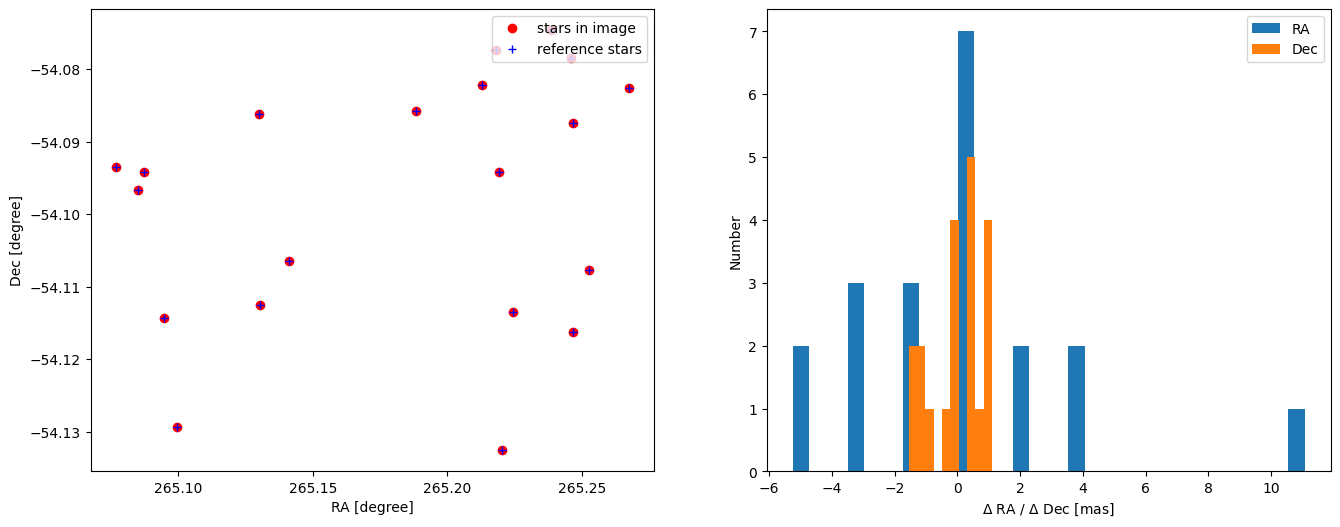

In [ ]:
# fig, axes = plt.subplots(1, 1, figsize= (6, 6))
# from matplotlib.ticker import MaxNLocator

# # axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
# axes.set_ylabel("Dec [degree]")
# axes.set_xlabel("RA [degree]")
# axes.xaxis.set_major_locator(MaxNLocator(5))
# axes.legend(loc=1)
fig, axes = plt.subplots(1, 2, figsize= (16, 6))
from matplotlib.ticker import MaxNLocator
# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

axes[0].plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
axes[0].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
axes[0].set_ylabel("Dec [degree]")
axes[0].set_xlabel("RA [degree]")
axes[0].xaxis.set_major_locator(MaxNLocator(5))
axes[0].legend(loc=1)


axes[1].hist((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000 * np.mean(np.cos(match_res_dec_gaia_uniqe / 180 * np.pi)), label="RA", bins=10, rwidth=0.3)
axes[1].hist((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000, label="Dec", bins=10, rwidth=1)
axes[1].set_xlabel(r"$\Delta$ RA / $\Delta$ Dec [mas]")
axes[1].set_ylabel("Number")
axes[1].legend(loc=1)

## 更新底片模型

### 全体星应用初步模型

In [ ]:
sext_flags = sext_out_filter[:]["FLAGS"]
sext_out_x = sext_out_filter[:]["X_IMAGE"][sext_flags == 0]
sext_out_y = sext_out_filter[:]["Y_IMAGE"][sext_flags == 0]

sext_out_xieta = function.use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD_PRE, cof_xy)
sext_out_radec = function.ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

### 全体星天球位置匹配

In [ ]:
refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now, "magrp": ref_filter["RPmag(mag)"], "magg": ref_filter["Gmag(mag)"], "magbp": ref_filter["BPmag(mag)"]})
side_threshold = 0.00001

match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all.iloc[:, 0:2] - temp_lib) < side_threshold, axis=1) == 2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), refcat_lib_all.iloc[np.where(index == True)[0][0]])))

match_res_all = np.array(match_res_all)

### 计算更新的底片模型

In [ ]:
match_res_xi_gaia_all, match_res_eta_gaia_all = function.cel_ideal_coord(match_res_all[:, 3], match_res_all[:, 4], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all
Y_eta = match_res_eta_gaia_all

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)

for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag = match_res_all[:, band_index + 4]


print("the matched stars", len(match_x))

# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 6
cof_mag = 3

A_CD = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)
print(A_CD)

the matched stars 1091
[[-1.34336796e-06  2.42452746e-07 -9.32574958e-11  1.17608915e-14
   3.58646439e-13  7.14737517e-15 -1.36032658e-17 -2.27849093e-19
  -1.67097808e-17  4.13502590e-19 -1.51320993e-22  7.63528839e-23
   1.53606314e-23  1.52839264e-22 -1.90314623e-22  1.59030726e-27
   1.51068880e-26  6.78939012e-27 -2.74691526e-26 -1.48508688e-27
  -1.71152199e-26  4.19898453e-30  2.10238326e-30 -3.88248899e-30
   1.85913920e-30  5.69437396e-30 -1.31454064e-30  4.08948201e-30
   1.68106490e-07 -9.13079223e-09  1.69758627e-10]
 [ 7.20756728e-07  1.21224667e-10 -2.42595835e-07 -2.34027882e-13
  -8.49213889e-15 -6.51938844e-13  2.59236605e-20  1.56370829e-17
  -1.12523034e-19  2.00919481e-17 -6.70081665e-23 -3.70238257e-23
  -1.80767907e-22  1.06711823e-22 -1.35326535e-22  1.11248038e-28
   3.06478762e-26 -3.43894412e-27  1.69764477e-26  2.91155383e-26
  -1.28997074e-26  1.00420654e-30  1.22305556e-30 -4.14955559e-30
  -1.89357786e-30  1.92562316e-30 -6.28090090e-30 -7.70542273e-31
  

### 再应用更新的底片模型

In [ ]:
match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD, cof_xy, cof_mag)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


# 残差
dis_xi = (match_xieta[0] - gaia_xieta[0])
dis_eta = (match_xieta[1] - gaia_xieta[1])
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

print(np.std(dis_ra), np.std(dis_dec), cof_xy, cof_mag)

2.393801173293193 1.1265369935716338 6 3


In [ ]:
# 保存
cof_mag_orders = 4
cof_xy = 6
for cof_mag in np.arange(1, cof_mag_orders + 1):

    A_CD_LOOP = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)

    match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD_LOOP, cof_xy, cof_mag)
    match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
    gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
    gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)

    # 残差
    dis_xi = (match_xieta[0] - gaia_xieta[0])
    dis_eta = (match_xieta[1] - gaia_xieta[1])
    dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
    dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

    match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "DIS_XI": dis_xi, "DIS_ETA": dis_eta, "MAG": match_mag})

    with open(f'match_res/match_{band_short}_{unkonw_index}_{exp_time}_{cof_xy}_{cof_mag}.pkl', 'wb') as f:
        pickle.dump(match_res_pickle, f)

In [ ]:
# match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "DIS_XI": dis_xi, "DIS_ETA": dis_eta, "MAG": match_mag})

# with open(f'match_res/match_{band_short}_{unkonw_index}_{exp_time}.pkl', 'wb') as f:
#     pickle.dump(match_res_pickle, f)

# 残差分析

## 残差图

### 网格化

In [ ]:
# create bins
bins_num = 1
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_xi, dis_eta))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# mag-distortion
bins_x_id, bins_y_id = function.match_box_id(match_x, match_y, bins_x, bins_y)

### 星等残差图

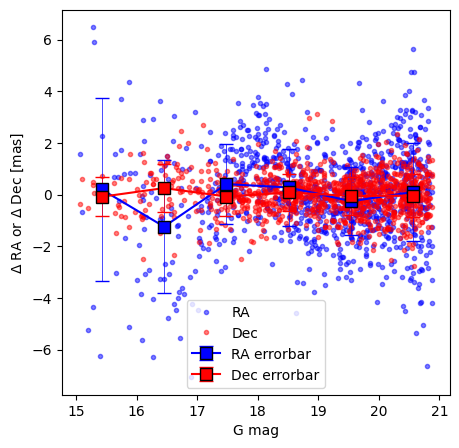

In [ ]:
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        index_box = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag[index_box]
        match_x_box = match_x[index_box]
        match_y_box = match_y[index_box]
        dis_ra_box = dis_ra[index_box]
        dis_dec_box = dis_dec[index_box]

        dis_ra_box, dis_dec_box, match_mag_box, filter = function.sigma_filter_2(dis_ra_box, dis_dec_box, match_mag_box, 3)
        index_mag = (match_mag_box < 29) & (match_mag_box > 15)

        dis_ra_box = dis_ra_box[index_mag]
        dis_dec_box = dis_dec_box[index_mag]
        match_mag_box = match_mag_box[index_mag]

        bin_centers_mag_box, bins_mean_dis_ra_box, bins_std_dis_ra_box = bins_divide(match_mag_box, dis_ra_box, 6)
        bin_centers_mag_box, bins_mean_dis_dec_box, bins_std_dis_dec_box = bins_divide(match_mag_box, dis_dec_box, 6)

        axe = axes if bins_num == 1 else axes[i][j]
        axe.plot(match_mag_box, dis_ra_box, '.', c='blue', label="RA", alpha = 0.5)
        axe.plot(match_mag_box, dis_dec_box, '.', c='red', label="Dec", alpha = 0.5)
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_ra_box, yerr=bins_std_dis_ra_box, ecolor='blue',elinewidth=0.5,marker='s',mfc='blue',mec='k',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="blue",label="RA errorbar")
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_dec_box, yerr=bins_std_dis_dec_box, ecolor='red',elinewidth=0.5,marker='s',mfc='red',mec='k',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="red",label="Dec errorbar")

        axe.set_xlabel(f"{band_short_capital} mag")
        axe.set_ylabel(r"$\Delta$ RA or $\Delta$ Dec [mas]")

        axe.legend()

### 位置残差图

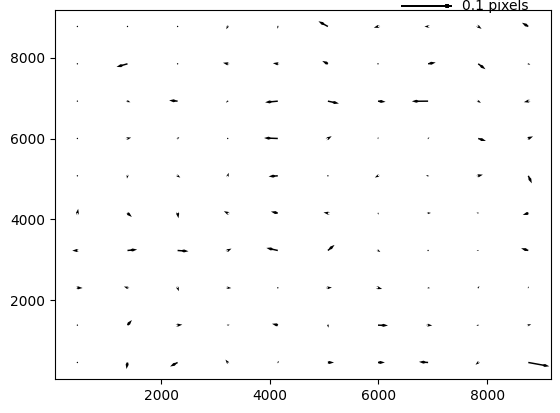

In [ ]:
bins_num = 10
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
dis_res_xy = [np.vstack((match_x[filter][index_mag], match_y[filter][index_mag], dis_ra[filter][index_mag], dis_dec[filter][index_mag]))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

fig, axes = plt.subplots(1, 1)
quiver_scale = 9216
quiver_show_scale = 0.1
quiver = axes.quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten() / 50, distort_mean_values_y.flatten() / 50, scale=1 / quiver_scale, angles = 'xy', scale_units="xy", headwidth=2, headlength=3, width=0.003)
axes.quiverkey(quiver, 0.8, 1.01, quiver_show_scale, f"{quiver_show_scale} pixels",labelpos='E', coordinates='axes')